# Pendulum
[Documentation](https://gymnasium.farama.org/environments/classic_control/pendulum/)  
This environment is part of the Classic Control environments which contains general information about the environment.

## Description
The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

## Imports

In [1]:
# import standard libraries
import os
import base64
import random
import time
import copy
from collections import namedtuple, deque

# import third-party libraries
import gymnasium as gym
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import imageio
import cv2
from IPython.display import clear_output, display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

## Hardware infos

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1070 (UUID: GPU-19cef1c2-e216-e824-c98e-660394f8a4bb)


In [3]:
print(f"torch.version.cuda=[{torch.version.cuda}]")
print(f"torch.cuda.is_available({torch.cuda.is_available()})")      

torch.version.cuda=[11.7]
torch.cuda.is_available(True)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Create directories

In [5]:
os.makedirs('img', exist_ok=True)
os.makedirs('saves', exist_ok=True)
print('./img :')
!ls -al img
print('./saves :')
!ls -al saves

./img :
total 18848
drwxr-xr-x 1 thiba 197609       0 Jun 19 19:25 .
drwxr-xr-x 1 thiba 197609       0 Jun 19 21:11 ..
drwxr-xr-x 1 thiba 197609       0 May  2 23:35 .ipynb_checkpoints
-rw-r--r-- 1 thiba 197609 6874961 May  2 22:24 acrobot.gif
-rw-r--r-- 1 thiba 197609 3911365 May  2 22:03 cartpole.gif
-rw-r--r-- 1 thiba 197609 1297387 May  2 23:32 dqn_acrobot.gif
-rw-r--r-- 1 thiba 197609   15131 May  2 23:49 gym.png
-rw-r--r-- 1 thiba 197609 3763789 May  2 22:46 mountain_car.gif
-rw-r--r-- 1 thiba 197609 3422774 Jun 19 20:42 pendulum.gif
./saves :
total 596
drwxr-xr-x 1 thiba 197609      0 Jun 19 20:44 .
drwxr-xr-x 1 thiba 197609      0 Jun 19 21:11 ..
-rw-r--r-- 1 thiba 197609  47392 May  2 23:31 dqn_acrobot_model.h5
-rw-r--r-- 1 thiba 197609 138495 Jun 19 20:07 pendulum_actor_model.pth
-rw-r--r-- 1 thiba 197609 138503 Jun 19 21:10 pendulum_actor_model2.pth
-rw-r--r-- 1 thiba 197609 139015 Jun 19 20:07 pendulum_critic_model.pth
-rw-r--r-- 1 thiba 197609 139087 Jun 19 21:10 pendulum_

## Utils

In [6]:
def print_infos(ep_len_mean, ep_rew_mean, min_rew, ep_min_rew, episodes, fps, time_elapsed, total_timesteps, actor_loss, critic_loss, learning_rate, n_updates):
    print(f"- rollout/")
    print(f"    - ep_len_mean     : {ep_len_mean}")
    print(f"    - ep_rew_mean     : {ep_rew_mean}")
    print(f"    - min_rew         : {min_rew}")
    print(f"    - ep_min_rew      : {ep_min_rew}")
    print(f"")
    print(f"- time/")
    print(f"    - episodes        : {episodes}")
    print(f"    - fps             : {fps}")
    print(f"    - time_elapsed    : {time_elapsed}")
    print(f"    - total_timesteps : {total_timesteps}")
    print(f"")
    print(f"- train/")
    print(f"    - actor_loss      : {actor_loss}")
    print(f"    - critic_loss     : {critic_loss}")
    print(f"    - learning_rate   : {learning_rate}")
    print(f"    - n_updates       : {n_updates}")

In [7]:
def save_gif(img_list, path):
    # Convert the list of frames to a numpy array
    resized_img_array = []
    for img in img_list:
        img_pil = Image.fromarray(img)
        # Make sure width and height are divisible by 16
        img_resized_pil = img_pil.resize((500, 500))
        img_resized = np.array(img_resized_pil)
        resized_img_array.append(img_resized)
    
    # Create gif video
    fps = 20
    imageio.mimsave(path, resized_img_array, 'GIF', duration=int(1000 * 1/fps), loop=0)

In [8]:
def plot_history(reward_history, rolling_window=20, lower_limit=None, upper_limit=None, plot_rw=True, plot_rm=True):
    """
    Function to plot reward history and its rolling mean with some optional arguments.

    Args:
        reward_history (list): A list of rewards for each episode.
        rolling_window (int): The number of episodes for computing the rolling mean.
        lower_limit (int): Starting episode index for plotting.
        upper_limit (int): Ending episode index for plotting.
        plot_rw (bool): A flag for plotting raw reward history.
        plot_rm (bool): A flag for plotting rolling mean reward history.

    Returns:
        None
    """
    
    # If lower_limit and upper_limit are not provided, use the whole reward_history
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
   
    # Create a DataFrame and calculate the rolling mean
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    # Plot the results
    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()

    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

## Hyperparameters

In [9]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0.00

## Experience Replay

In [10]:
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

In [11]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## Define Actor Network

In [12]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

## Define Critic Network

In [13]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Ornstein-Uhlenbeck

In [14]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

## DDPG Agent

In [15]:
class Agent:
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        self.actor_loss = None
        
        # Critic Network 
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic_loss = None

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        self.n_updates = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def save_model(self):
        torch.save(self.actor_local.state_dict(), 'saves/pendulum_actor_model2.pth')
        torch.save(self.critic_local.state_dict(), 'saves/pendulum_critic_model2.pth')

    def load_model(self):
        self.actor_local.load_state_dict(torch.load('saves/pendulum_actor_model2.pth'))
        self.critic_local.load_state_dict(torch.load('saves/pendulum_critic_model2.pth'))
    
    def get_lr(self):
        for param_group in self.critic_optimizer.param_groups:
            return param_group['lr']

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_loss = critic_loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_loss = actor_loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
        self.n_updates += 1

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Train

In [16]:
def ddpg(env, agent, n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    start_time_elapsed = time.time()
    total_timesteps = 0
    min_rew = -1500 
    ep_min_rew = 0
    for i_episode in range(1, n_episodes+1):
        # function to override printlines from previous loop iteration 
        clear_output(wait=True)
        state, _ = env.reset()
        agent.reset()
        score = 0
        timestep = 0
        done = False
        while not done and timestep <= max_t:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = torch.from_numpy(next_state.T).float().squeeze(0).numpy()
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            timestep += 1
            total_timesteps += 1
        scores_deque.append(score)
        scores.append(score)

        if i_episode % 4 == 0:
            time_elapsed = time.time() - start_time_elapsed
            if min_rew <= np.mean(scores_deque):
                min_rew = np.mean(scores_deque)
                ep_min_rew = i_episode
                agent.save_model()
            print_infos(
                timestep,
                np.mean(scores_deque),
                min_rew,
                ep_min_rew, 
                i_episode,
                int(total_timesteps / time_elapsed),
                int(time_elapsed),
                total_timesteps,
                agent.actor_loss,
                agent.critic_loss,
                agent.get_lr(),
                agent.n_updates
            )

        if np.mean(scores_deque) >= -160.0: # based on the leaderboard -160 would be a good score https://github.com/openai/gym/wiki/Leaderboard#pendulum-v0
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
    return scores

### create environment

In [17]:
env = gym.make('Pendulum-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = Agent(state_size, action_size, random_seed=0)
scores = ddpg(env, agent, 2000)
env.close()

- rollout/
    - ep_len_mean     : 200
    - ep_rew_mean     : -699.326416015625
    - min_rew         : -405.52117919921875
    - ep_min_rew      : 600

- time/
    - episodes        : 2000
    - fps             : 91
    - time_elapsed    : 4384
    - total_timesteps : 400000

- train/
    - actor_loss      : -308.8093566894531
    - critic_loss     : 1698.087646484375
    - learning_rate   : 0.001
    - n_updates       : 399872


### Plot rewards

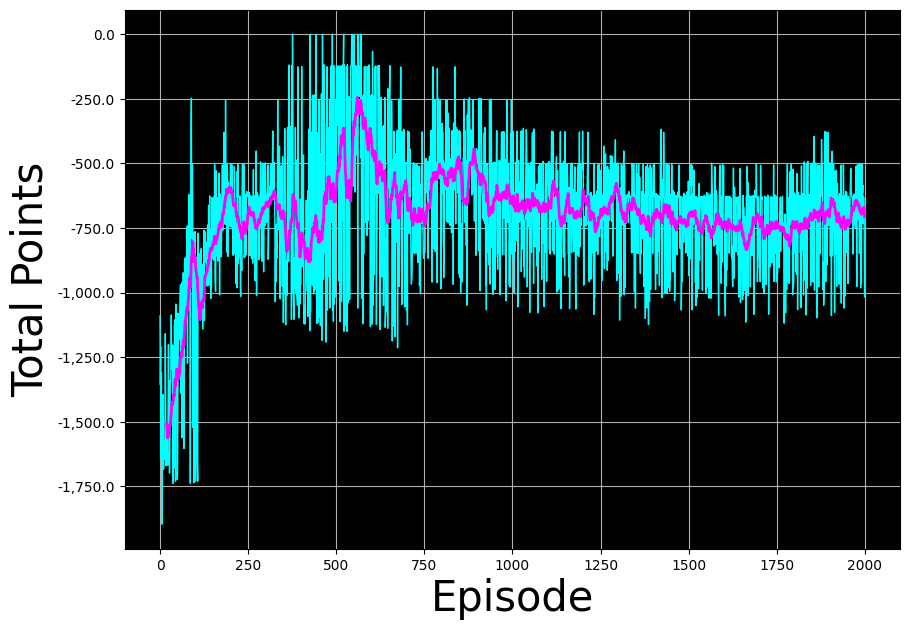

In [18]:
# Plot the point history
plot_history(scores)

## Visualizing
### create environment

In [19]:
env = gym.make('Pendulum-v1', render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

agent2 = Agent(state_size, action_size, random_seed=0)
agent2.load_model()

In [20]:
screen_list = []
for i in range(5):
    state, _ = env.reset()
    done = False
    timestep = 0
    episode_reward = 0
    while not done:
        #Select an action
        # s = copy.copy(state)
        action = agent2.act(state).squeeze(0)
    
        # Printing env render (rgb_array)
        screen = env.render()
        # Add title to the screen
        screen = cv2.putText(
            np.array(screen),
            f"Iteration=[{i}] Timestep=[{timestep +1}]",
            (25, 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 0),
            1,
            cv2.LINE_AA
        )
        screen_list.append(screen)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.from_numpy(next_state.T).float().squeeze(0).numpy()
        done = terminated or truncated
    
        state = next_state
        episode_reward += reward
    
        timestep += 1

### Save gif

In [21]:
path = f"./img/pendulum.gif"
save_gif(screen_list, path)

### Embed the video


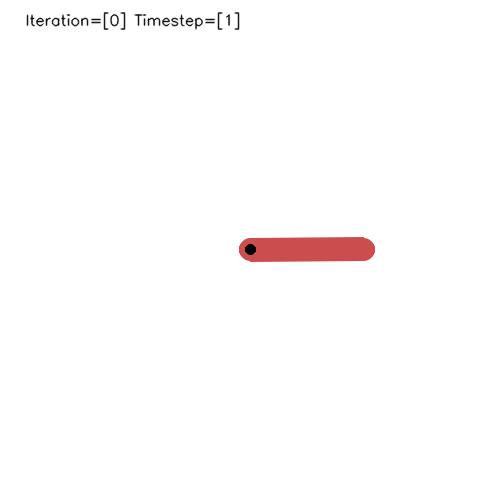

In [22]:
video = open(path, 'rb').read()
b64_video = base64.b64encode(video)
video_tag = '<img src="data:image/gif;base64,{0}">'.format(b64_video.decode())

display(HTML(video_tag))